In [14]:
from collections import Counter
import os
from glob import glob
import re
import numbers

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter



sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

## Create df with performance data

### Clone map

In [15]:
data = [['bulk', 's0', 'P3861_218.clean.dedup_ac.txt', 'ss0'], 
        ['E', 's1', 'P9855_2085_S108_L004_ac.txt', 'ss1'],
        ['A', 's2', 'P9855_2089_S112_L004_ac.txt', 'ss2'],
        ['A', 's3', 'P9855_2090_S113_L004_ac.txt', 'ss3'],
        ['D', 's4', 'P9855_2091_S114_L004_ac.txt', 'ss4'],
        ['E', 's5', 'P9855_2093_S116_L005_ac.txt', 'ss5'],
        ['D', 's6', 'P9855_2096_S119_L005_ac.txt', 'ss6'],
        ['F', 's7', 'P9855_2101_S124_L006_ac.txt', 'ss7'],
        ['F', 's8', 'P9855_2102_S125_L006_ac.txt', 'ss8'],
        ['B', 's9', 'P9855_2104_S127_L006_ac.txt', 'ss9'],
        ['C', 's10', 'P9855_2110_S133_L007_ac.txt', 'ss10'],
        ['C', 's11', 'P9855_2111_S134_L007_ac.txt', 'ss11'],
        ['B', 's12', 'P9855_2112_S135_L007_ac.txt', 'ss12']]

clones_map_raw = pd.DataFrame(data, columns=['clone', 'tree_id', 'cell_id', 'node_name'])

clones_map_raw

,clone,tree_id,cell_id,node_name
0,bulk,s0,P3861_218.clean.dedup_ac.txt,ss0
1,E,s1,P9855_2085_S108_L004_ac.txt,ss1
2,A,s2,P9855_2089_S112_L004_ac.txt,ss2
3,A,s3,P9855_2090_S113_L004_ac.txt,ss3
4,D,s4,P9855_2091_S114_L004_ac.txt,ss4
5,E,s5,P9855_2093_S116_L005_ac.txt,ss5
6,D,s6,P9855_2096_S119_L005_ac.txt,ss6
7,F,s7,P9855_2101_S124_L006_ac.txt,ss7
8,F,s8,P9855_2102_S125_L006_ac.txt,ss8
9,B,s9,P9855_2104_S127_L006_ac.txt,ss9


In [16]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [17]:
n_samples_per_clone = clones_map_raw.clone.value_counts()
n_samples_per_clone

E       2
A       2
D       2
F       2
B       2
C       2
bulk    1
Name: clone, dtype: int64

### Load info from mt-SCITE runs

In [18]:
scite_input_path = f'../../../mt-SCITE/mt-SCITE_output/P9855/stdout/'

scite_stdout_filenames = list(glob(os.path.join(scite_input_path, '*.txt')))

# Get log likelihood scores and n trees
exp_std = []
lhood = []
n_trees = []

#for filename in sorted(scite_stdout_filenames, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
for filename in sorted(scite_stdout_filenames):
    print(filename)
    name = os.path.basename(filename).rsplit('.', 1)[0].rsplit('.', 1)[0]
    #print(name)
    exp_std.append(name)
    #print(files)
    file = open(filename, "r")
    for line in file:
        if 'best log score for tree:' in line:
            score = line.split('	')[1].rstrip()
            lhood.append(score)
            lhood = [float(x) for x in lhood]
            #print(lhood)
        if 'opt tree' in line:
            n = line.split(' opt')[0].lstrip()
            n_trees.append(n)
            n_trees = [int(x) for x in n_trees]
            #print(n_trees)
            

../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_1.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_10.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_2.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_3.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_4.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_5.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_6.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_7.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_8.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_9.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0002_1.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0002_10.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0002_2.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0002_3.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0002_4.stdo

### Load info from pmats

In [19]:

pmat_input_path = f'../../data/P9855_matrix_output/'

pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))

pmat_names = []
n_pmat_rows = []

for filename in sorted(pmats):
#for filename in sorted(pmats, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
    name = os.path.basename(filename).rsplit('.', 1)[0]
    print(name)
    file = open(filename, "r")
    n = len(file.readlines())
    n_pmat_rows.append(n)
    pmat_names.append(name)

# store in a dict
pmat_info = {pmat_names[i]: n_pmat_rows[i] for i in range(len(pmat_names))}


0.0001
0.0002
0.0003
0.0004
0.0005
0.0006
0.0007
0.0008
0.0009
0.001


In [20]:
pmat_info

{'0.0001': 176,
 '0.0002': 64,
 '0.0003': 40,
 '0.0004': 35,
 '0.0005': 34,
 '0.0006': 30,
 '0.0007': 28,
 '0.0008': 26,
 '0.0009': 24,
 '0.001': 24}

### Create df containing info from mt-SCITE and pmat

In [21]:
samples = 13

performance = pd.DataFrame(exp_std)
performance['lhood'] = lhood
performance['lhood'] = performance['lhood'].astype(float)

performance['n_trees'] = n_trees
performance['error_rate'] = performance[0].str.split('_').str.get(0)

performance = performance.rename(columns={0: 'run'})
performance = performance.set_index('run')

runs = performance.index.tolist()
performance = performance.sort_index()

performance['n_muts'] = performance['error_rate'].map(pmat_info)

performance['entries'] = performance['n_muts']*samples

performance['lhood_entries'] = performance['lhood']/performance['entries']

In [22]:
performance

,lhood,n_trees,error_rate,n_muts,entries,lhood_entries
run,,,,,,
0.0001_1,-1596.571797,9,0.0001,176,2288,-0.697802
0.0001_10,-1505.973680,6,0.0001,176,2288,-0.658205
0.0001_2,-1516.470922,1,0.0001,176,2288,-0.662793
0.0001_3,-1538.185084,22,0.0001,176,2288,-0.672284
0.0001_4,-1528.997347,7,0.0001,176,2288,-0.668268
...,...,...,...,...,...,...
0.001_5,-31.430335,2,0.001,24,312,-0.100738
0.001_6,-31.430335,2,0.001,24,312,-0.100738
0.001_7,-31.430335,2,0.001,24,312,-0.100738


### Read trees

In [23]:
MAX_TREES_PER_ERROR_RATE = 100
all_trees = {}
for run, n in zip(runs, n_trees):
    all_trees[run] = []
    for idx in range(min(MAX_TREES_PER_ERROR_RATE, n)):
        #print(n)
        tree_filename = f'../../../mt-SCITE/mt-SCITE_output/P9855/{run}_map{idx}.gv' 
        tree = nx.drawing.nx_pydot.read_dot(tree_filename)
        tree.remove_node('\\n')
        all_trees[run].append(tree)
        #print(error_rate)

In [24]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

# Avg purity of nodes with >1 sample

In [25]:
import warnings
warnings.filterwarnings('ignore')

performance['avg_purity_more_than_one_sample'] = 0
performance['frac_purity_100_more_than_one_sample'] = 0
for error_rate, trees in all_trees.items():
    avg_purities = []
    frac_purities_100 = []
    #n_purities_100 = []
    for t in trees:
        #print(error_rate, get_root_node(t))
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        print(clones_count)
        more_than_one_sample = clones_count.sum(axis=0) > 1
        p = purity(clones_count).loc[:, more_than_one_sample]
        #print(p)
        
        # exclude mutations shared by all clones
        p = p.T
        p = p.mask((p.A > 0) & (p.B > 0) & (p.C > 0) & (p.D > 0) & (p.E > 0) & (p.F > 0))
        p = p.dropna().T
        
        
        # Average purity
        avg_purity = p.max(axis=0).mean()
        avg_purities.append(avg_purity)
        #print(avg_purities)
        # Fraction of nodes with 100% purity
        is_purity_100 = np.isclose(p.max(axis=0), 1.0)
        frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
        frac_purities_100.append(frac_purity_100)

    performance.loc[error_rate, 'avg_purity_more_than_one_sample'] = avg_purities[0]
    performance.loc[error_rate, 'frac_purity_100_more_than_one_sample'] = frac_purities_100[0]

!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 33
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  156  145  143  155  39  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0    0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2    2    2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2    2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2    2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2    2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2    2    2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2    2    2   2   

      128  97  102  81  177  
bulk    0   0    0   0    1  
E       2   2    2   2    2  
A       2   2    2   2    2  
D       2   2    2   2    2  
F       2   2    2   2    2  
B       2   2    2   2    2  
C       2   2    2   2    2  

[7 rows x 188 columns]
!! possible mutation in a lea

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  145  102  97  128  81  39  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0    0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2    2   2    2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2    2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2    2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2    2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2    2   2    2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2    2   2   2   

      134  156  143  177  
bulk    0    0    0    1  
E       2    2    2    2  
A       2    2    2    2  
D       2    2    2    2  
F       2    2    2    2  
B       2    2    2    2  
C       2    2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 174
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  145  102  97  128  81 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  158  134  74  155  128  97  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0    0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    1    2   2    2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2    2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2    2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2    2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    1    2   2    2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2    2    2   2   

      81  143  39  177  
bulk   0    0   0    1  
E      2    2   2    2  
A      2    2   2    2  
D      2    2   2    2  
F      2    2   2    2  
B      2    2   2    2  
C      2    2   2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 33
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  158  134  74  155  128  97  \
b

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  158  134  74  39  128  97  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0   0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    1    2   2   2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2   2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2   2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2   2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    1    2   2   2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2   2    2   2   

      81  143  155  177  
bulk   0    0    0    1  
E      2    2    2    2  
A      2    2    2    2  
D      2    2    2    2  
F      2    2    2    2  
B      2    2    2    2  
C      2    2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 33
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  158  134  74  39  128  97  \
bu

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  158  134  74  39  128  97  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0   0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    1    2   2   2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2   2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2   2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2   2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    1    2   2   2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2   2    2   2   

      81  143  155  177  
bulk   0    0    0    1  
E      2    2    2    2  
A      2    2    2    2  
D      2    2    2    2  
F      2    2    2    2  
B      2    2    2    2  
C      2    2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 33
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  158  134  74  39  128  97  \
bu

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  97  74  39  155  152  95  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0    0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2    2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2    2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2    2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2   2   2    2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   2    2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   2   2   2    2    2   2   

      143  134  128  177  
bulk    0    0    0    1  
E       2    2    2    2  
A       2    2    2    2  
D       2    2    2    2  
F       2    2    2    2  
B       2    2    2    2  
C       2    2    2    2  

[7 rows x 190 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  97  74  39  155  152  95  \
bulk   1   0   0   0   0   0   0   0   0   0  ..

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  102  128  95  156  134  51  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0    0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2    2   2    2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2    2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2    2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2    2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2    2   2    2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2    2    2   2   

      74  145  155  177  
bulk   0    0    0    1  
E      2    2    2    2  
A      2    2    2    2  
D      2    2    2    2  
F      2    2    2    2  
B      2    2    2    2  
C      2    2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 106
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  102  128  95  156  134

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  127  5  102  97  39  81  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0  0    0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2  2    2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2  2    2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2  2    2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2  2    2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2  2    2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2  2    2   2   2   2   

      98  155  145  177  
bulk   0    0    0    1  
E      2    2    2    2  
A      2    2    2    2  
D      2    2    2    2  
F      2    2    2    2  
B      2    2    2    2  
C      2    2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 33
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  127  5  102  97  39  81  \
bulk   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  127  5  102  97  39  81  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0  0    0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2  2    2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2  2    2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2  2    2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2  2    2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2  2    2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2  2    2   2   2   2   

      98  155  145  177  
bulk   0    0    0    1  
E      2    2    2    2  
A      2    2    2    2  
D      2    2    2    2  
F      2    2    2    2  
B      2    2    2    2  
C      2    2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 33
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  127  5  102  97  39  81  \
bulk   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  155  5  102  97  39  81  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0  0    0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2  2    2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2  2    2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2  2    2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2  2    2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2  2    2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2  2    2   2   2   2   

      98  127  145  177  
bulk   0    0    0    1  
E      2    2    2    2  
A      2    2    2    2  
D      2    2    2    2  
F      2    2    2    2  
B      2    2    2    2  
C      2    2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 33
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  155  5  102  97  39  81  \
bulk   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  155  5  102  97  39  81  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0  0    0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2  2    2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2  2    2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2  2    2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2  2    2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2  2    2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2  2    2   2   2   2   

      98  127  145  177  
bulk   0    0    0    1  
E      2    2    2    2  
A      2    2    2    2  
D      2    2    2    2  
F      2    2    2    2  
B      2    2    2    2  
C      2    2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 33
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  155  5  102  97  39  81  \
bulk   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  155  5  102  97  39  81  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0  0    0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2  2    2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2  2    2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2  2    2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2  2    2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2  2    2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2  2    2   2   2   2   

      98  127  145  177  
bulk   0    0    0    1  
E      2    2    2    2  
A      2    2    2    2  
D      2    2    2    2  
F      2    2    2    2  
B      2    2    2    2  
C      2    2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 33
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  155  5  102  97  39  81  \
bulk   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  95  102  134  74  143  156  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0    0    0   0    0    0   
E      0   1   0   0   0   1   0   0   0   0  ...   2    2    2   2    2    2   
A      0   0   1   1   0   0   0   0   0   0  ...   2    2    2   2    2    2   
D      0   0   0   0   1   0   1   0   0   0  ...   2    2    2   2    2    2   
F      0   0   0   0   0   0   0   1   1   0  ...   2    2    2   2    2    2   
B      0   0   0   0   0   0   0   0   0   1  ...   2    2    2   2    2    2   
C      0   0   0   0   0   0   0   0   0   0  ...   2    2    2   2    2    2   

      39  97  128  177  
bulk   0   0    0    1  
E      2   2    2    2  
A      2   2    2    2  
D      2   2    2    2  
F      2   2    2    2  
B      2   2    2    2  
C      2   2    2    2  

[7 rows x 187 columns]
!! possible mutation in a leaf: not found 33
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 135
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  95  102  134  74  143  156  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0    0    0   0    0    0   
E      0   1   0   0   0   1   0   0   0   0  ...   2    2    2   2    2    2   
A      0   0   1   1   0   0   0   0   0   0  ...   2    2    2   2    2    2   
D      0   0   0   0   1   0   1   0   0   0  ...   2    2    2   2    2    2   
F      0   0   0   0   0   0   0   1   1   0  ...   2    2    2   2    2    2   
B      0   0   0   0   0   0   0   0   0   1  ...   2    2    2   2    2    2   
C      0   0   0   0   0   0   0   0   0   0  ...   2    2    2   2    2    2   

      39  97  128  177  
bulk   0   0    0    1  
E      2   2    2    2  
A      2   2    2    2  
D      2   2    2    2  
F      2   2    2    2  
B      2   2    2    2  
C      2   2    2    2  

[7 rows x 187 columns]
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  33  46  56  27  36  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   2   2   2   2   2   

      50  14  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  49  33  46  56  27  36  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  49  33  46  56  50  36  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      27  14  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  49  33  46  56  50  36  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  51  63  56  39  36  27  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      46  30  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  51  63  56  39  36  27  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  26  14  39  36  27  46  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   2   2   2   2   2   

      56  30  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  26  14  39  36  27  46  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  26  14  39  36  27  46  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   2   2   2   2   2   

      56  30  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  26  14  39  36  27  46  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  42  16  56  46  39  50  36  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   2   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      27  14  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  42  16  56  46  39  50  36  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  49  51  27  50  39  36  46  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      30  56  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  49  51  27  50  39  36  46  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  63  30  27  46  56  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      39  50  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  63  30  27  46  56  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  26  27  14  36  39  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      46  50  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  26  27  14  36  39  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  26  27  56  36  14  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      46  50  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  26  27  56  36  14  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  26  56  36  50  14  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      46  27  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  26  56  36  50  14  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  26  56  36  50  14  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      46  27  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  26  56  36  50  14  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  63  49  30  50  36  56  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      46  27  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  63  49  30  50  36  56  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  55  16  39  27  30  50  36  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      14  56  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  55  16  39  14  30  50  36  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  51  49  46  56  36  50  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      27  39  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  51  49  46  56  50  36  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  33  23  10  32  20  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   

      22  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  18  34  10  32  20  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  6  27  34  30  32  24  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   

      20  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  6  26  39  32  37  20  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  19  21  22  32  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   

      10  20  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  19  21  22  32  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  31  2  33  24  37  10  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   2   2   2   2   

      22  20  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  7  21  37  20  24  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  21  19  20  37  24  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   

      10  22  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  21  19  20  37  24  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  39  12  32  10  24  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   

      22  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  39  12  32  10  24  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  19  21  22  32  25  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   

      37  20  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  19  21  22  32  25  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  23  33  10  24  25  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   

      37  20  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  23  33  10  24  25  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  34  12  37  32  25  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   

      24  20  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  34  12  37  32  25  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  19  21  10  32  37  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   

      20  22  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  19  21  10  32  37  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  39  12  20  10  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   

      22  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  39  12  20  10  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  7  19  20  37  24  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   2   2   2   2   

      10  22  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  7  19  20  37  24  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  25  34  23  35  31  18  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      15  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  25  34  23  35  31  18  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  34  23  35  15  18  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      31  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  34  23  35  15  18  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  34  23  35  31  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      10  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  34  23  35  17  15  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  32  34  23  35  10  15  31  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      18  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  32  34  23  35  10  15  31  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  23  34  35  18  17  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      31  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  23  34  35  17  18  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  25  23  34  35  31  10  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      17  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  25  23  34  35  31  10  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  23  34  35  18  31  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      10  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  23  34  35  15  10  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  23  34  35  17  31  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      10  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  23  34  35  31  17  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  28  31  22  34  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   1   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      30  9  35  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  3  2  24  26  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E   

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  32  5  27  22  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   1   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   2   2   

      9  14  35  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  31  28  21  22  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  10  26  24  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   2   2   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   1   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   2   2   

      9  14  35  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  10  26  24  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  31  21  28  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   1   2   2   2   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      9  14  35  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  31  21  28  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  26  2  24  34  9  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2  2   2   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0  0   0   0  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   0   0  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   1  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0  2   2   

      17  30  35  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  26  3  24  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  10  24  26  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   2   2   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   1   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   2   2   

      9  14  35  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  31  28  21  22  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  19  5  27  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   1   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   2   2   

      14  9  35  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  19  5  27  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  32  19  25  22  34  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   1   1   1   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      30  9  35  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  32  19  25  22  34  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  1  11  25  29  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2  2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   2   2   

      8  13  31  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  19  1  18  29  15  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0  0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  20  28  26  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   1   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      8  13  31  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  25  19  1  29  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  28  26  20  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   1   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      27  8  31  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  28  26  20  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  28  20  26  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   1   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      27  8  31  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  28  20  26  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  28  26  20  15  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   1   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0   0   0   2  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2  2   

      27  13  31  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  28  20  26  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  3  22  9  24  8  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  2   2  2   2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0   0  0   0  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0  0   0  2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0  0   0  2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0  0   0  2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0  0   0  2   2   2   

      13  31  
bulk   0   1  
E      2   2  
A      2   2  
D      2   2  
F      2   2  
B      2   2  
C      2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  3  22  9  24  8  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  26  20  28  15  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   1   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0   0   0   2  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2  2   

      27  13  31  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  20  26  28  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  26  28  20  15  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   1   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0   0   0   2  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2  2   

      13  27  31  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  26  28  20  15  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E 

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  5  18  17  27  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2   2   2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   0   0  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0  2   2   

      13  25  29  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  5  18  17  27  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0  0   0   
E      0   1

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  26  19  24  21  8  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  2   2   

      13  15  29  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  3  20  9  22  13  8  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0  0   0   0  0   0   


[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  18  17  27  23  13  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   2   2   

      25  8  29  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  18  17  27  23  13  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  1  5  27  23  8  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   0   0  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0  2   2   

      25  15  29  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  19  24  26  21  8  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0   0   
E      0   1   0  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  23  5  1  27  8  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0  0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0  0   0  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0  2   2   

      13  15  29  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  23  5  1  27  8  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0  0   0   
E      0   1   0   0  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  26  19  24  21  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      13  8  29  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  26  19  24  21  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  22  23  18  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      24  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  22  23  18  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  1  22  16  17  26  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2  2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  1  16  22  17  26  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  17  18  23  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   

      24  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  17  25  23  20  18  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  3  2  21  19  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2  2  2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0  0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  3  2  21  19  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  18  23  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  18  23  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  20  25  23  18  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  20  25  23  18  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  22  20  18  23  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      8  24  27  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  3  9  2  21  19  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   0   
E      0   1   0   0   0   1

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  21  3  2  19  15  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2   2  2  2   2   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0  0  0   0   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0  0   0   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0  0   0   2  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0  0   0   2  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   2  2   

      24  27  
bulk   0   1  
E      2   2  
A      2   2  
D      2   2  
F      2   2  
B      2   2  
C      2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  21  3  2  19  15  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   0  0   
E      0   1   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  16  20  23  25  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  19  9  2  3  21  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0  0   0   
E      0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  26  1  16  17  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   2   

      24  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  5  1  16  17  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  23  20  18  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  16  23  20  18  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  9  23  18  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  9  23  18  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  17  23  20  18  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  17  23  20  18  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  3  21  9  2  19  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2   2  2  2   2  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0  0  0   0  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0  0   0  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0  0   0  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0  0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0  2   2   

      24  27  
bulk   0   1  
E      2   2  
A      2   2  
D      2   2  
F      2   2  
B      2   2  
C      2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  1  26  17  5  22  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0  0   
E      0   1   0   0   0   1  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  5  17  1  16  26  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0  0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  16  23  18  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  20  23  25  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  20  23  25  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  25  20  23  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  25  20  23  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E 

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  17  23  18  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  17  23  18  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  22  23  18  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  22  23  18  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  5  26  1  16  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0  0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   2   

      24  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  26  1  16  17  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  21  3  2  19  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2   2  2  2   2  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0  0  0   0  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0  0   0  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0  0   0  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0  0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0  2   2   

      12  27  
bulk   0   1  
E      2   2  
A      2   2  
D      2   2  
F      2   2  
B      2   2  
C      2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  21  3  2  19  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0  0   0   
E      0   1   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  22  23  20  18  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      12  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  22  23  20  18  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  19  3  9  2  21  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2  2  2  2   2  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0  0  0   0  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0  0   0  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0  0   0  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0  0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0  2   2   

      24  27  
bulk   0   1  
E      2   2  
A      2   2  
D      2   2  
F      2   2  
B      2   2  
C      2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  19  3  2  21  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0  0   0   
E      0   1   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  22  18  20  23  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  22  18  20  23  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  16  26  17  1  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2   2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   2   

      12  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  1  5  17  16  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  17  18  23  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  17  25  23  20  18  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  16  1  5  17  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0  0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  22  20  18  23  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  9  23  18  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   2   

      24  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  9  23  18  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  16  23  18  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  21  23  18  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  16  22  17  5  26  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2   2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  9  20  23  25  18  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  16  18  23  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  16  18  23  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  17  20  23  18  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  21  3  2  19  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  17  20  18  23  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  17  20  18  23  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  16  5  1  17  26  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0  0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0  0   0   0  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0  2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  1  16  26  17  22  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0  0   
E      0   1   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  21  18  20  23  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  21  18  20  23  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  1  22  17  16  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2  2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   2   

      8  24  27  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  20  25  23  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  22  16  17  5  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2   2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   2   

      12  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  22  16  17  5  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  5  26  1  17  22  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0  0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  5  26  1  17  22  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  17  23  20  18  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  17  18  20  23  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  1  16  17  5  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2   2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   2   

      24  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  1  16  17  5  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   
E      0   1   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  22  20  23  18  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      12  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  23  25  20  18  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  22  5  17  1  26  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  22  5  17  1  26  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  21  9  2  3  19  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2  2  2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0  0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0   2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  21  9  2  3  19  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0   0   
E      0   1   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  18  23  20  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  16  18  23  20  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  4  21  23  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  4  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  5  1  24  15  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0  0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  2  2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  18  3  2  17  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  20  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  20  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  1  24  15  5  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0   0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  2   2   2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  5  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  16  3  17  2  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  2   2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0   0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  16  2  17  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  1  5  24  15  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  2  2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0   0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  1  5  24  15  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  5  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  6  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  21  23  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  21  23  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  18  17  2  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2  2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0  0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  18  2  17  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  20  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  18  21  16  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  15  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  15  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  16  21  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  16  21  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  6  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  19  18  21  16  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  6  23  16  21  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  1  15  24  5  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   
E      0   1

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  6  16  21  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  4  16  21  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  24  15  5  1  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0  0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   2   2  2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  24  15  5  1  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  1  24  15  5  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  2   2   2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  24  1  15  5  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  24  1  5  15  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   2  2  2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  24  1  5  15  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  5  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  5  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  16  3  19  2  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  2   2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0   0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  16  3  19  2  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  15  24  5  1  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0  0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   2   2  2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  15  24  1  5  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  15  21  23  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  5  21  23  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  17  23  16  21  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  17  23  16  21  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  17  21  16  18  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  21  16  18  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  21  23  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  21  23  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  15  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

In [26]:
performance

,lhood,n_trees,error_rate,n_muts,entries,lhood_entries,avg_purity_more_than_one_sample,frac_purity_100_more_than_one_sample
run,,,,,,,,
0.0001_1,-1596.571797,9,0.0001,176,2288,-0.697802,0.645076,0.340909
0.0001_10,-1505.973680,6,0.0001,176,2288,-0.658205,0.746768,0.581818
0.0001_2,-1516.470922,1,0.0001,176,2288,-0.662793,0.757720,0.618182
0.0001_3,-1538.185084,22,0.0001,176,2288,-0.672284,0.644558,0.387755
0.0001_4,-1528.997347,7,0.0001,176,2288,-0.668268,0.793059,0.611940
...,...,...,...,...,...,...,...,...
0.001_5,-31.430335,2,0.001,24,312,-0.100738,0.924868,0.904762
0.001_6,-31.430335,2,0.001,24,312,-0.100738,0.924868,0.904762
0.001_7,-31.430335,2,0.001,24,312,-0.100738,0.924868,0.904762


# Plots

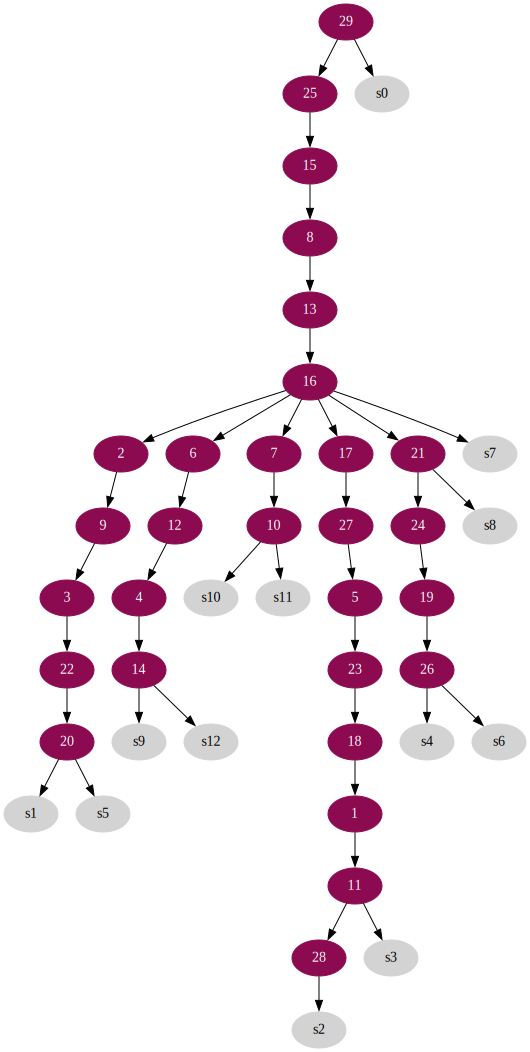

In [27]:
Source.from_file(f'../../../mt-SCITE/mt-SCITE_output/P9855/0.0007_1_map5.gv')

In [16]:
# Plot a tree
# Source.from_file(f'../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/0.0005_10_map0.gv')

In [17]:
#pd.set_option('display.max_rows', None)
#performance

## Tree Likelihood

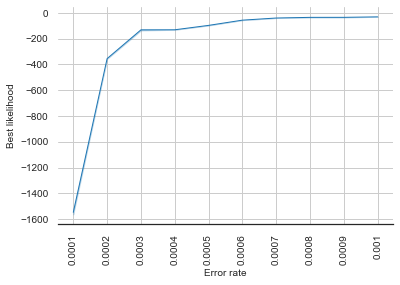

In [28]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="error_rate", y="lhood", lw=1) #marker='o'
    plt.grid(axis='both')
    #ax.set_xlim(0, 20)
    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Best likelihood')
    plt.xlabel('Error rate')

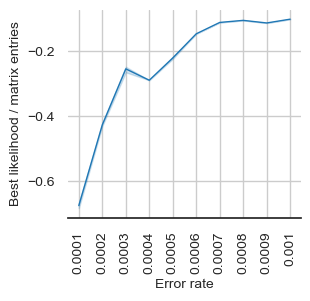

In [29]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="error_rate", y="lhood_entries", lw=1) #marker='o'
    plt.grid(axis='both')
    #ax.set_xlim(0, 20)
    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Best likelihood / matrix entries')
    plt.xlabel('Error rate')

#plt.savefig(f'../../data/P9855_figures/lhood_entries.svg', dpi=300, bbox_inches='tight', transparent=True)
#plt.savefig(f'../../data/P9855_figures/lhood_entries.jpg', dpi=300, bbox_inches='tight', transparent=True)

## Average purity

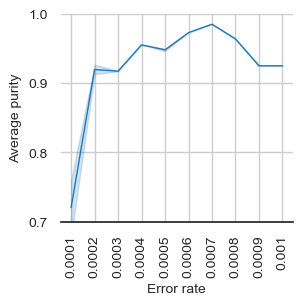

In [30]:

with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    ax = sns.lineplot(data=performance, x="error_rate", y="avg_purity_more_than_one_sample", markersize=4, lw=1)
    ax.set_ylim(0.7, 1.0)
    plt.grid(axis='both')
    plt.xticks(rotation=90)
    plt.ylabel('Average purity')
    plt.xlabel('Error rate')
    
    
plt.savefig(f'../../data/P9855_figures/avg_purity.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(f'../../data/P9855_figures/avg_purity.jpg', dpi=300, bbox_inches='tight', transparent=True)

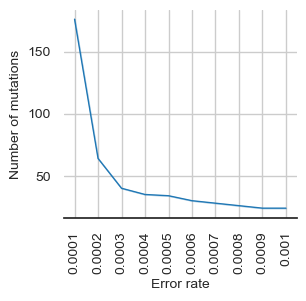

In [31]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="error_rate", y="n_muts", lw=1) #marker='o'
    plt.grid(axis='both')
    #ax.set_xlim(0, 20)
    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Number of mutations')
    plt.xlabel('Error rate')
    plt.savefig(f'../../data/P9855_figures/n_muts.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(f'../../data/P9855_figures/n_muts.jpg', dpi=300, bbox_inches='tight', transparent=True)

In [22]:
performance.rename(columns={'n trees': 'n_trees'}, inplace=True)

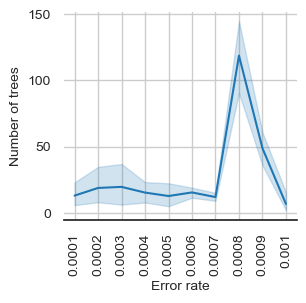

In [32]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):

    sns.lineplot(data=performance.reset_index(), x='error_rate', y="n_trees")

    plt.grid(axis='both')
    #plt.yscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Number of trees')
    plt.xticks(rotation = 90)
    
    #plt.savefig(f'../../data/P9855_figures/n_trees.svg', dpi=300, bbox_inches='tight', transparent=True)
    #plt.savefig(f'../../data/P9855_figures/n_trees.jpg', dpi=300, bbox_inches='tight', transparent=True)